In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import utils
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from typing import Iterator

In [199]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from datasets import load_dataset, iterable_dataset

ds = load_dataset("nielsr/CelebA-faces", streaming=True)['train']

In [29]:
class FacesIterDataset(utils.data.IterableDataset):
    def __init__(self, 
                 iterable: iterable_dataset.IterableDataset,
                 transforms: A.Compose
                ):
        self.iterable = iterable
        self.transforms = transforms

    def __iter__(self) -> Iterator[torch.Tensor]:
        for item in self.iterable:
            image = np.array(item['image'])
            image = self.transforms(image=image)['image']

            yield image

transforms = A.Compose([
    A.CenterCrop(160, 144, p=1),
    A.ToGray(1, p=1),
    A.Normalize(mean=0.4375, std=0.2708),
    ToTensorV2()
])

train_dataloader = utils.data.DataLoader(FacesIterDataset(ds, transforms),
                              batch_size = 8,
                              shuffle=False)

In [30]:
def denormalize(img: torch.Tensor, mean: float = 0.4375, std: float = 0.2708) -> np.ndarray:
    return np.clip((img.detach().numpy() * std + mean)*255, 0, 255).astype(np.uint8)

In [31]:
from math import ceil, prod

class Encoder(nn.Module):
    def __init__(self, 
                 img_size: tuple[int],
                 in_channels: int,
                 latent_dim: int,
                 hidden_layers: tuple[int]
                ):
        super().__init__()

        layers = []
        
        for layer in hidden_layers:
            layers.extend([
                nn.Conv2d(in_channels, layer, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(layer),
                nn.ELU()
            ])
            in_channels = layer

        self.encoder = nn.Sequential(*layers)
        
        self.origin_shape = hidden_layers[-1], ceil(img_size[0] / 2**len(hidden_layers)), ceil(img_size[1] / 2**len(hidden_layers))

        enc_dim = self.origin_shape[0] * self.origin_shape[1] * self.origin_shape[2]
        
        self.fc_mu = nn.Linear(enc_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_dim, latent_dim)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        x = torch.flatten(self.encoder(x), start_dim=1)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

In [32]:
class Decoder(nn.Module):
    def __init__(self,
                 out_channels: int,
                 latent_dim: int,
                 origin_shape: tuple[int],
                 hidden_layers: tuple[int]
                ):
        super().__init__()

        self.fc = nn.Linear(latent_dim, prod(origin_shape))

        self.reshape = lambda z: z.view(-1, *origin_shape)

        layers = []
        
        for curr, next in zip(hidden_layers, hidden_layers[1:]):
            layers.extend([
                nn.ConvTranspose2d(curr, next, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.BatchNorm2d(next),
                nn.ELU()
            ])
        
        layers.append(nn.ConvTranspose2d(hidden_layers[-1], out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self.fc(z)
        z = self.reshape(z)

        return self.decoder(z)

In [33]:
class VAE(nn.Module):
    def __init__(self, 
                 img_size: tuple[int],
                 in_channels: int,
                 latent_dim: int = 256,
                 hidden_layers: tuple[int] = (8, 32, 64, 128)
                ):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.encoder = Encoder(img_size, in_channels, latent_dim, hidden_layers)
        self.decoder = Decoder(in_channels, latent_dim, self.encoder.origin_shape, hidden_layers[::-1])
    
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        
        return self.decoder(z), mu, logvar
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps * std + mu
    
    def loss(
             self,
             reconstr: torch.Tensor,
             target: torch.Tensor,
             mu: torch.Tensor, 
             logvar: torch.Tensor
            ) -> tuple[torch.Tensor, torch.Tensor]:
        
        reconstruction_loss = F.mse_loss(reconstr, target)
        regularization_term = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1)

        return reconstruction_loss, regularization_term.mean()

    def sample(self, num: int) -> torch.Tensor:
        z = torch.randn(num, self.latent_dim)

        return self.decoder(z)

In [34]:
vae = VAE((160, 144), 1, 128)

In [35]:
epoch = 5
lr = 3e-4
grad_clip = 1
optimizer = optim.AdamW(vae.parameters(), lr)
# TODO: add scheduler

In [ ]:
vae.train()
vae.to(device)

for e in range(epoch):
    for i, inputs in enumerate(train_dataloader):
    
        inputs.to(device)

        reconstructions, mu, logvar = vae(inputs)

        reconstruction_loss, kl_loss = vae.loss(reconstructions, inputs, mu, logvar)
        elbo_loss = reconstruction_loss + kl_loss

        optimizer.zero_grad()
        elbo_loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), grad_clip)
        optimizer.step()

        print(f'Reconstrucion loss: {reconstruction_loss.item()} | KL loss: {kl_loss.item()}')
        
        if (i % 20 == 0):
            vae.eval()
            display(Image.fromarray(denormalize(vae.sample(1).squeeze((0, 1)))))
            vae.train()


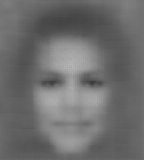

In [404]:
vae.eval()
display(Image.fromarray(denormalize(vae.sample(1).squeeze((0, 1)))))